# Homework 2 Exercise 1 - Bayesian Belief Network

Brennan McFarland   
bfm21

## Problem Description

Suppose an autonomous robot has a depth sensor mounted on it that repeatedly samples whether there is currently an obstacle in front of it (C).  The robot is programmed to take evasive maneuvers whenever an obstacle comes within its sensor distance (O), but there is also random noise in the sensor readings that can indicate an obstacle exists where there is none and vice versa (N).  The robot also keeps track of the last depth sensor reading (L), as a positive reading is more likely to be an actual obstacle rather than noise if it is persistent across samples.  Let us suppose that given a certain set of sensor data we want the probability that there is an obstacle in the way.

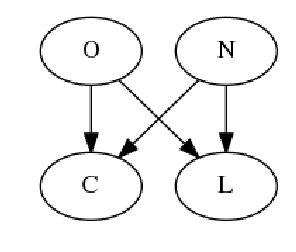

In [2]:
from graphviz import Digraph
import matplotlib.pyplot as plt
import matplotlib.image as imtool

image_format = 'png'
dot = Digraph(format=image_format)
dot.node('O', 'O')
dot.node('N', 'N')
dot.node('C', 'C')
dot.node('L', 'L')
dot.edges(['OC', 'OL', 'NC', 'NL'])
path = 'exercise1-graph'
dot.render(path)
imorg = imtool.imread(path + '.' + image_format)
plt.axis('off')
plt.imshow(imorg) # NOTE: the first time it might not show the image, if it doesn't just execute this block again

## Probabilities

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math


p_o = .2
p_n = .3

print("Suppose the robot is preprogrammed with the following prior probabilities:");
print("P(O) = ", p_o)
print("P(N) = ", p_n)

p_c_given_o_n = p_l_given_o_n = .96
p_c_given_o_not_n = p_l_given_o_not_n = .9
p_c_given_not_o_n = p_l_given_not_o_n = .4
p_c_given_not_o_not_n = p_l_given_not_o_not_n = .01

print("And the following conditional probabilities:")
print("P(C|O,N) = ", p_c_given_o_n)
print("P(C|O,~N) = ", p_c_given_o_not_n)
print("P(C|~O,N) = ", p_c_given_not_o_n)
print("P(C|~O,~N) = ", p_c_given_not_o_not_n)
print("P(L|O,N) = ", p_l_given_o_n)
print("P(L|O,~N) = ", p_l_given_o_not_n)
print("P(L|~O,N) = ", p_l_given_not_o_n)
print("P(L|~O,~N) = ", p_l_given_not_o_not_n)
print("Note that for Python output I use the ~ symbol for negation.")

Suppose the robot is preprogrammed with the following prior probabilities:
P(O) =  0.2
P(N) =  0.3
And the following conditional probabilities:
P(C|O,N) =  0.96
P(C|O,~N) =  0.9
P(C|~O,N) =  0.4
P(C|~O,~N) =  0.01
P(L|O,N) =  0.96
P(L|O,~N) =  0.9
P(L|~O,N) =  0.4
P(L|~O,~N) =  0.01
Note that for Python output I use the ~ symbol for negation.


Note that the existence of noise does not preclude the possibility of an actual obstacle; the sensor could have noise at the same time as an actual obstacle exists.

Let us define the corresponding Bayesian Belief Network Model in PyMC3 as follows.  Notice that since all variables are binary, they are all defined with the Bernoulli distribution, but C and L are dependent on O and N and thus we must use switches to determine their probabilities given values of O and N:

In [4]:
import pymc3
from pymc3 import Bernoulli
from pymc3.math import switch

model = pymc3.Model()

with model:
    o = Bernoulli('Obstacle', p_o)
    n = Bernoulli('Noise', p_n)
    c = Bernoulli('Current reading', switch(o, switch(n, p_c_given_o_n, p_c_given_o_not_n), switch(n, p_c_given_not_o_n, p_c_given_not_o_not_n)))
    l = Bernoulli('Last reading', switch(o, switch(n, p_l_given_o_n, p_l_given_o_not_n), switch(n, p_l_given_not_o_n, p_l_given_not_o_not_n)))
    

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/user/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Sample Generation

Next we can have PYMC3 perform Monte-Carlo sampling for us and generate the following trace:

Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [Obstacle, Noise, Current reading, Last reading]
100%|██████████| 20500/20500 [00:19<00:00, 1058.67it/s]
The number of effective samples is smaller than 25% for some parameters.


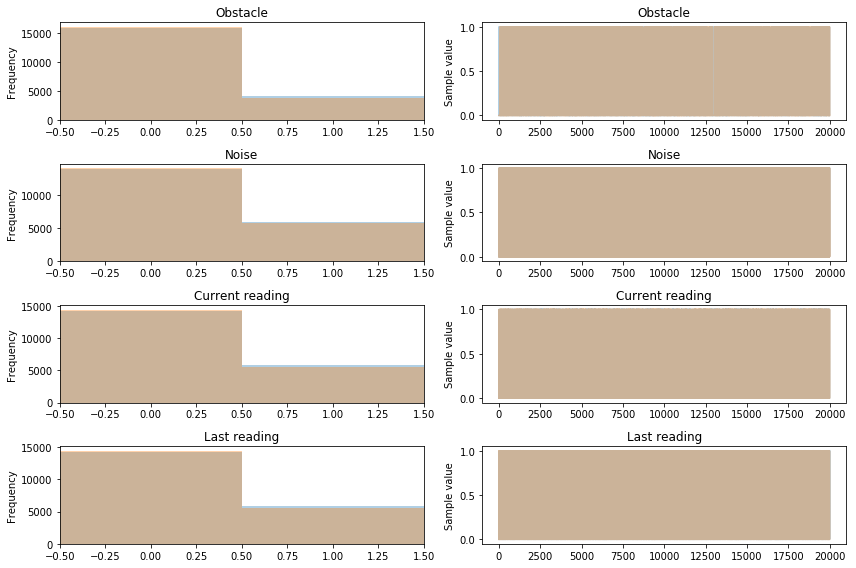

In [5]:
%matplotlib inline
samples = 20000
with model:
    trace = pymc3.sample(samples, chains=2)
    pymc3.traceplot(trace)

## Posterior Inference

We can use the conditional probability function to calculate posterior probabilities:

In [6]:
def conditional_probability(trace, event, cond):
    # find all samples satisfy conditions
    for k, v in cond.items():
        trace = [smp for smp in trace if smp[k] == v]
    # record quantity of all samples fulfill condition
    nCondSample = len(trace)
    # find all samples satisfy event
    for k, v in event.items():
        trace = [smp for smp in trace if smp[k] == v]
    # calculate conditional probability
    return len(trace) / nCondSample

Now we can calculate the posteriors probabilities of obstacles being in the way for all possible sensor data:

In [6]:
print('P(O|C,L) = ',
     conditional_probability(trace,
                            {'Obstacle' : 1},
                            {'Current reading' : 1, 'Last reading' : 1}))
print('P(O|C,~L) = ',
     conditional_probability(trace,
                            {'Obstacle' : 1},
                            {'Current reading' : 1, 'Last reading' : 0}))
print('P(O|~C,L) = ',
     conditional_probability(trace,
                            {'Obstacle' : 1},
                            {'Current reading' : 0, 'Last reading' : 1}))
print('P(O|~C,~L) = ',
     conditional_probability(trace,
                            {'Obstacle' : 1},
                            {'Current reading' : 0, 'Last reading' : 0}))

P(O|C,L) =  0.8233753868126636
P(O|C,~L) =  0.21485411140583555
P(O|~C,L) =  0.19365721997300944
P(O|~C,~L) =  0.0027324537434616283


Notice that the resulting probabilities are what we would expect: the probability of an obstacle is highest when both the current and last sensor reading indicate so, then when the current but not last indcates so, then when the last but not the current reading, then when neither reading indicates so.

## Variable Elimination

Now let's use variable elimination to manually derive a conditional probability expression.  Say we want to do this for P(N|C), the probability that there is noise given a currently positive sensor reading.

Straight summation gives us the expression  
$P(N|C) = \alpha P(C,N) = \alpha \sum_{O,L} P(C|O,N)P(L|O,N)P(O)P(N)$  
Since we're only summing over O and L, we can pull P(N) out of the sum  
$P(N|C) = \alpha P(N) \sum_{O,L} P(C|O,N)P(L|O,N)P(O)$  
Similarly, we can pull out terms that are not dependent on L to get  
$P(N|C) = \alpha P(N) \sum_{O} P(O)P(C|O,N) \sum_{L} P(L|O,N)$  
and since $\sum_{L} P(L|O,N)$ sums to 1, we can eliminate it.  All other variables are ancestors of the query variable (O, N) or an evidence variable (C), so our final variable-eliminated expression is  
$P(N|C) = \alpha P(N) \sum_{O} P(O)P(C|O,N)$  
We know our normalizing constant, $\alpha$, to be $\frac{1}{P(C)}$, which we can find by summing over all values of O and N  
$P(C) = P(C|O,N)+P(C|O,\neg{N})+P(C|\neg{O},N)+P(C|\neg{O},\neg{N})$  
Our final expression is thus $P(N|C) = \frac{1}{P(C|O,N)+P(C|O,\neg{N})+P(C|\neg{O},N)+P(C|\neg{O},\neg{N})}P(N) \sum_{O} P(O)P(C|O,N)$  

In [27]:
print("So by substituting our variables' values in we get")
print("1/(", p_c_given_o_n, "+", p_c_given_o_not_n, "+", p_c_given_not_o_n, "+", p_c_given_not_o_not_n, ")*", p_n, "*(" \
     , p_o, "*", p_c_given_o_n, "+", (1-p_o), "*", p_c_given_not_o_n, ")")
print("= ", 1/(p_c_given_o_n+p_c_given_o_not_n+p_c_given_not_o_n+p_c_given_not_o_not_n)*p_n*(p_o*p_c_given_o_n+(1-p_o)*p_c_given_not_o_n))

So by substituting our variables' values in we get
1/( 0.96 + 0.9 + 0.4 + 0.01 )* 0.3 *( 0.2 * 0.96 + 0.8 * 0.4 )
=  0.06766519823788548


which is our calculated value for P(N|C).  We can support its correctness by obtaining the same probability from our model:

In [30]:
print('P(N|C) = ',
     conditional_probability(trace,
                            {'Noise' : 1},
                            {'Current reading' : 1}))

P(N|C) =  0.5408126573175117


In [ ]:
#TODO: why don't they match???